<a href="https://colab.research.google.com/github/pedrogaldo/PERFECT-PITCH/blob/IA/PERFECT_PITCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [ ]:
#numpy
import numpy as np #para trabajar con arrays y transformadas

#matplotlib
import matplotlib.pyplot as plt #para graficar diferentes cosas dentro del arhivo de audio

#pandas
import pandas as pd

#IPython
import IPython.display as ipd #para poder reproducir archivos de audio

#librosa
import librosa, librosa.display #para cargar y procesar audio 

#MIDIUtil
#from MidiUtil import MIDIFile #generar archivos MIDI

#music21
import music21 as music

# **Parametros**

In [ ]:
samplerate = 44100 #frecuencia de samples
nfft = 2048 #tamaño transofrmada de fourier
overlap = 0.5 #
hop_length = 512 #cantidad de samples entre "cuadros"
bins = 72 # espacios para guardar frecuencias
umbral_cqt = -60 #umbral para eliminar sonidos no deseados del cqt
magnitud = 4 #
pre_post_max = 6 

# **Cargar audio:**

In [ ]:
filename = '/content/audio piano.mp3'
x, samplerate = librosa.load(filename)
ipd.Audio (x, rate=samplerate)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


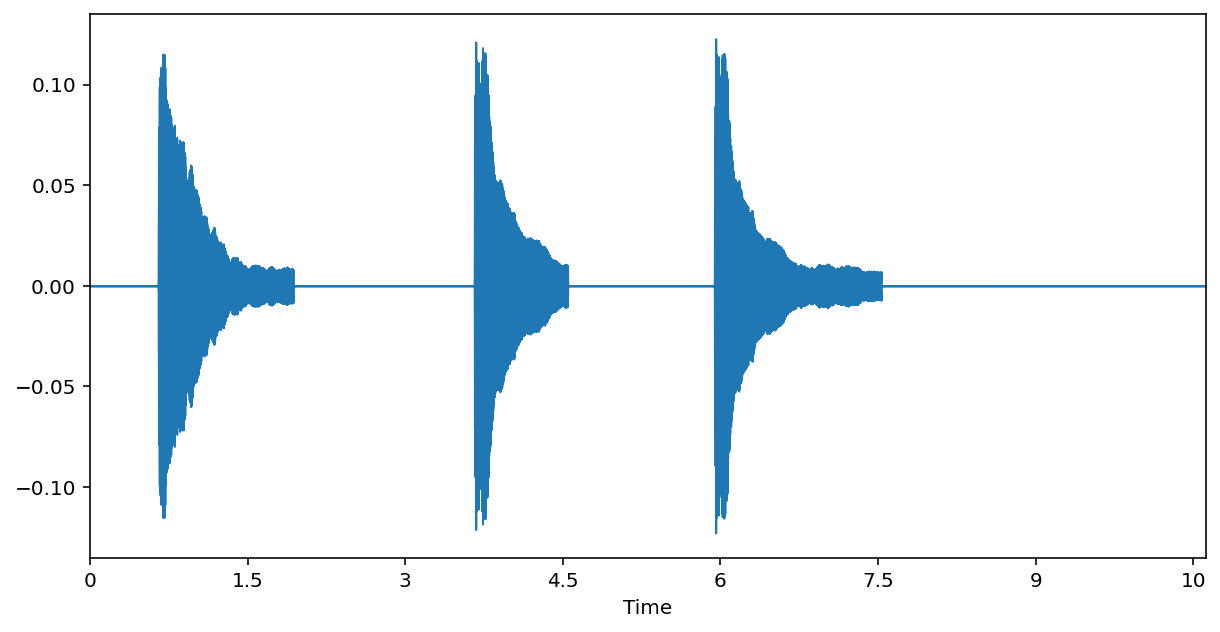

In [ ]:
#forma de onda
plt.figure(figsize=(10,5))
librosa.display.waveplot(x,samplerate)

# **Transformada:**

Estimacion de las frecuencias y traduccion a notas

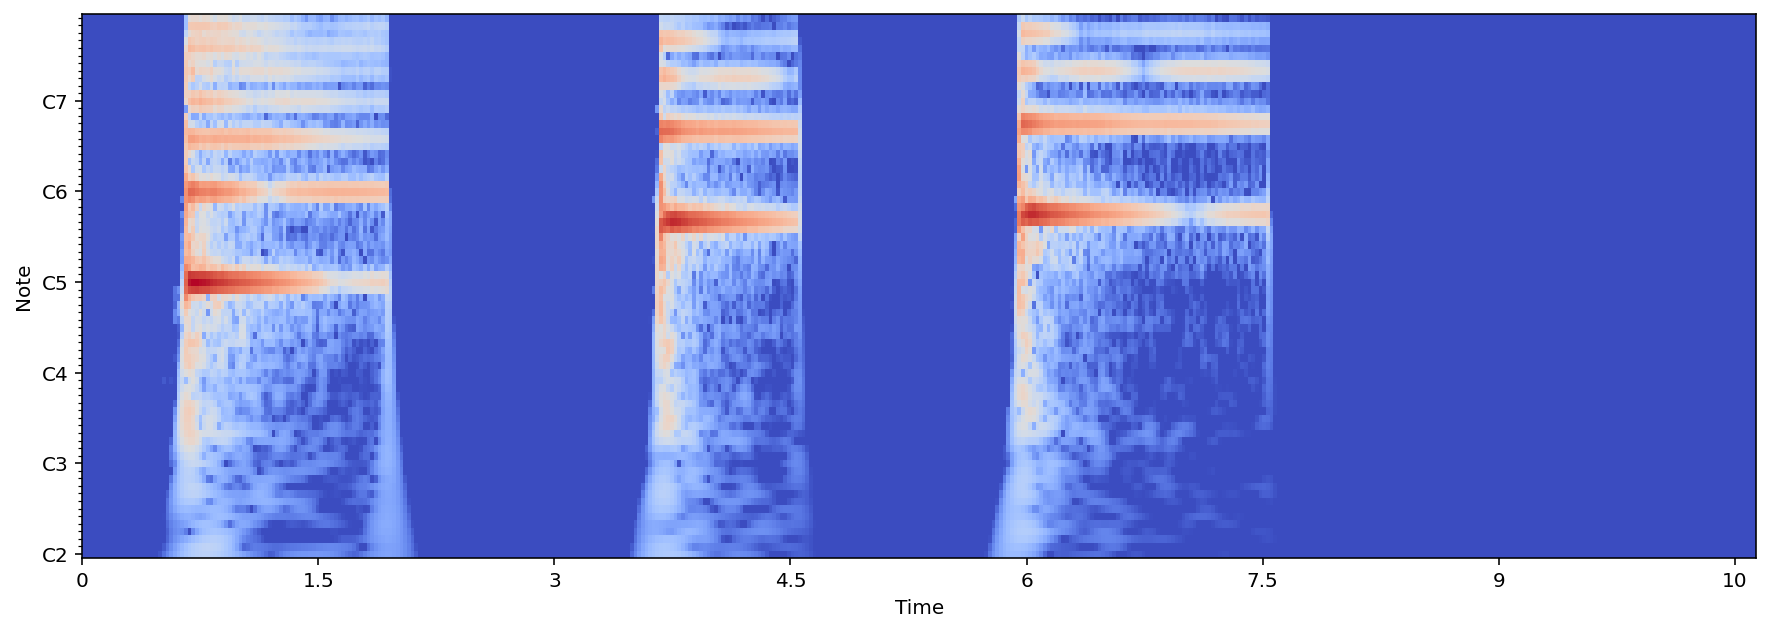

In [ ]:
#funcion para calcular la transformada

  
fmin = librosa.midi_to_hz(36)

cqt = librosa.cqt(x, sr=samplerate, hop_length=512, fmin=None, n_bins=bins, bins_per_octave=12, tuning=0.0)
logCqt = librosa.amplitude_to_db(np.abs(cqt))

plt.figure(figsize=(15,5))
librosa.display.specshow(logCqt, sr=samplerate, x_axis='time', y_axis='cqt_note', fmin=fmin, cmap='coolwarm')

In [ ]:
#esta funcion es una que encontramos la cual estima frecuencias usando el metodo de correlacion
def estimar_frecuencias(segment, samplerate, frec_min=50.0, frec_max=20000.0):
    
    # Compute autocorrelation of input segment.
    correlacion = librosa.autocorrelate(segment)
    
    lim_min = samplerate/frec_max
    lim_max = samplerate/frec_min
    correlacion[:int(lim_min)] = 0
    correlacion[int(lim_max):] = 0
    
    # Find the location of the maximum autocorrelation
    i = correlacion.argmax()
    frecuencias = float(samplerate)/i
    return frecuencias

In [ ]:
#funcion para eliminar los ruidos de fondo o notas no deseadas
def cqt_umbral(cqt,thres=umbral_cqt):
    cqt_final=np.copy(cqt)
    cqt_final[cqt<thres]=-120
    return cqt_final

cqt_umbral(cqt,thres=umbral_cqt)

array([[ 4.3520199e-08-7.39588213e-09j, -1.1583077e-07-5.59671278e-08j,
        -8.8047564e-08+1.95815673e-07j, ...,
         2.3982582e-07+4.36343264e-08j,  8.3555655e-08-1.52023105e-07j,
        -5.5310643e-08-1.13236155e-07j],
       [-5.1178318e-07-2.88759372e-09j, -2.1851071e-07+4.62685080e-07j,
         3.2769060e-07+4.03325458e-07j, ...,
         4.0649306e-07+2.10835822e-07j,  3.6020421e-07-3.20098167e-07j,
        -1.6430600e-07-4.63978893e-07j],
       [-3.7397538e-07+5.14986587e-09j, -1.4632323e-07+3.45147100e-07j,
         2.6618250e-07+2.65143797e-07j, ...,
         5.3894564e-07-1.12691261e-07j,  2.7985422e-07-5.41890586e-07j,
        -2.7142849e-07-5.78542654e-07j],
       ...,
       [-5.7644820e-06-8.20728374e-08j,  2.3921973e-06-1.32582545e-06j,
        -8.1014633e-07+3.66063455e-06j, ...,
         4.9662822e-06-3.88220042e-06j, -3.3403105e-06-2.88820772e-08j,
        -2.0034329e-06+4.12808504e-06j],
       [-1.1694911e-05-9.55671311e-08j, -1.9606700e-06-3.54033932e-0

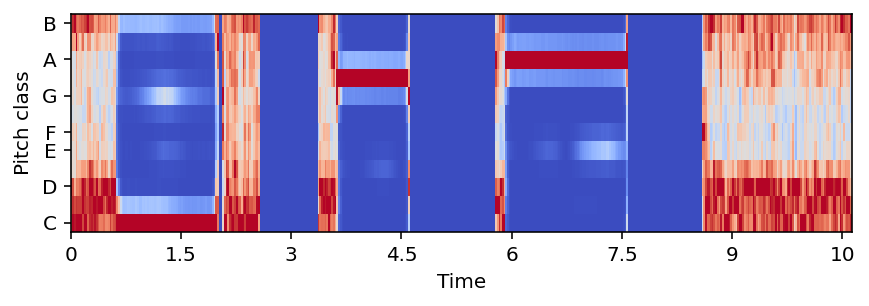

In [ ]:
cromagrama = librosa.feature.chroma_stft(x, sr=samplerate, hop_length=hop_length)
plt.figure(figsize=(7, 2))
librosa.display.specshow(cromagrama, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

# **Onset detection:**

detectar eventos musicales, es decir, cuando empieza y cuando termina cada nota

(0.0, 458.0)

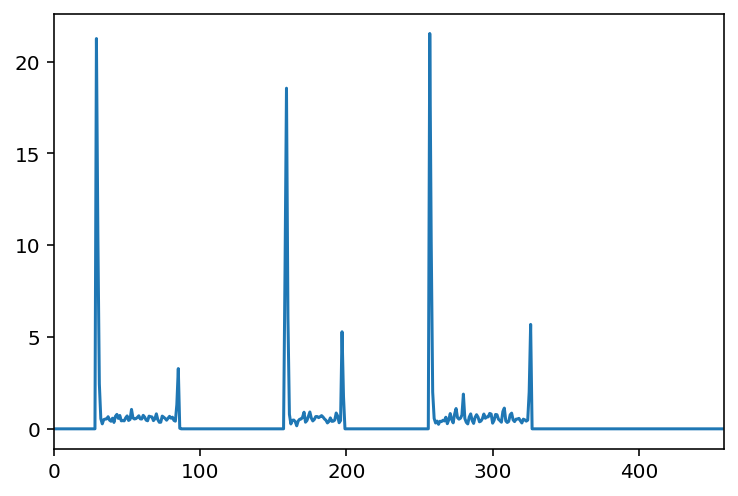

In [ ]:
#importante 
#def calc_onset_envelope(x, cqt):
onset_envelope = librosa.onset.onset_strength(x, sr=samplerate, aggregate=np.mean, hop_length=hop_length)
plt.plot(onset_envelope)
plt.xlim(0, len(onset_envelope))
#return onset_envelope

#calc_onset_envelope(x,cqt)

[0.00000000e+00 6.73378685e-01 1.97369615e+00 3.69197279e+00
 4.57433107e+00 5.96752834e+00 7.56970522e+00 5.43846168e+03]


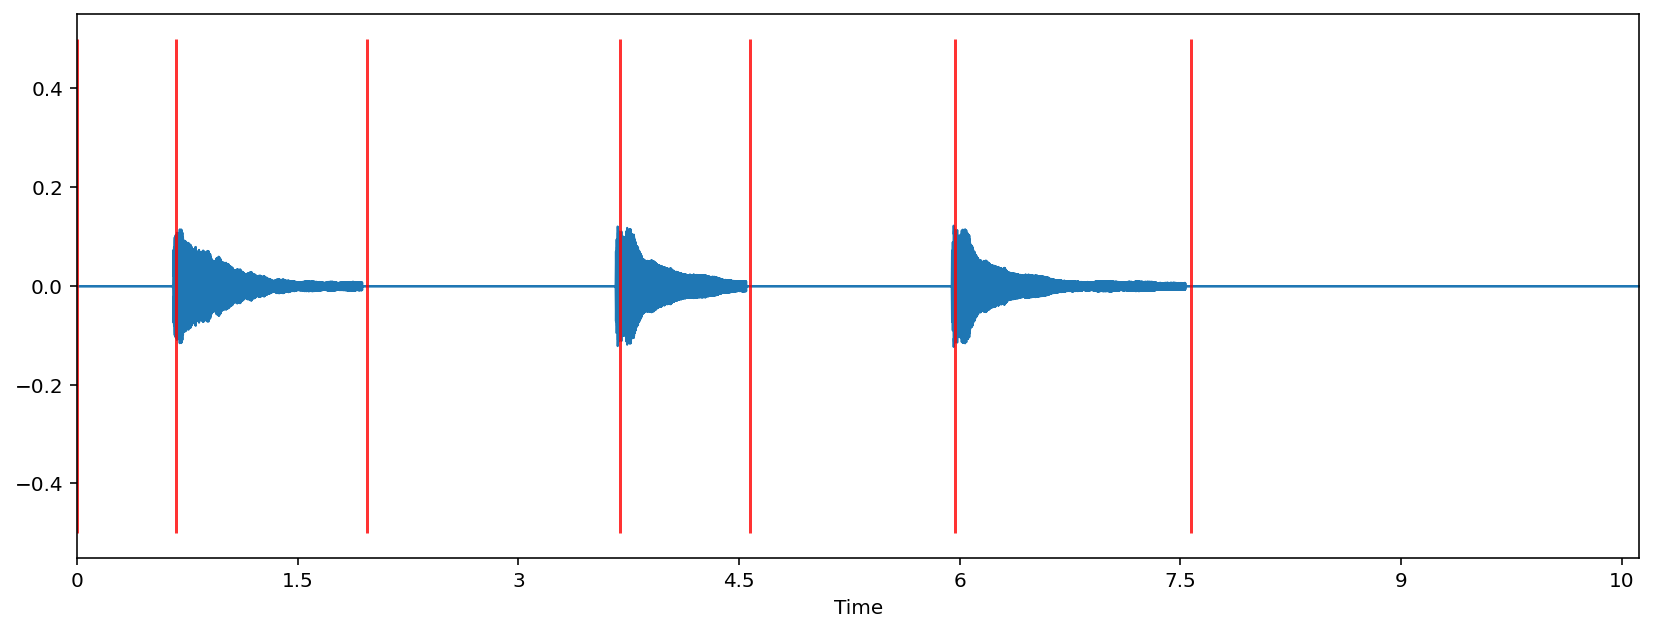

In [ ]:
#estima adonde hay un onset
onsets = librosa.onset.onset_detect(onset_envelope=onset_envelope,
                                          sr=samplerate, units = 'frames',
                                          hop_length=hop_length, 
                                          backtrack=False,
                                          pre_max=6,
                                          post_max=6)


onset_limites = np.concatenate([[0], onsets, [len(x)]])


#convierte la estimacion de los onsets a segundos
onset_segs = (librosa.frames_to_time(onset_limites)) 
print (onset_segs)


#grafico de los onsets sobre la forma de onda
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=samplerate)
plt.vlines(onset_segs, -0.5, 0.5, color='r', alpha=0.8) 

# **Mas aspectos musicales**
duracion de las notas, generador de sinusoides, tempo etc...


## Duracion de las notas

In [ ]:
#sacar duracion de las notas
def duracion(onset_segs):
  PairNum = len(onset_segs) / 2
  LoopsCompleted = 0
  EvaluatedIndex = 1
  Duration = []
  while LoopsCompleted < PairNum:
  
    Duration.append(onset_segs[EvaluatedIndex] - onset_segs[EvaluatedIndex - 1])
    EvaluatedIndex += 2
    LoopsCompleted += 1

  #umbral para eliminar sonidos con poca duracion

  #umbral_duracion = onset_segs.filter(umbral_duracion, onset_segs)
  #print(umbral_duracion)

  return Duration

duracion(onset_segs)

## Traduccion a ondas senoidales:


In [ ]:
def generar_sinusoide(frecuencias, sr, Duration):
    n = np.arange(Duration)
    return 0.2*np.sin(2*np.pi*frecuencias*n/float(sr)) 

In [ ]:
def generar_sinusoides_por_estimacion(x, onsets, i, samplerate):
    n0 = onset_limites[i]
    n1 = onset_limites[i+1]
    frecuencias = estimar_frecuencias(x[n0:n1], samplerate)
    return generar_sinusoide(frecuencias, samplerate, n1-n0)

In [ ]:
y = np.concatenate([
    generar_sinusoides_por_estimacion(x, onsets, i, samplerate)
    for i in range(len(onset_limites)-1)
])

In [ ]:
#audio de las notas en ondas senoidales
ipd.Audio(y, rate=samplerate)

## tempo y beat tracking:

In [ ]:
def sacarTempo(x,samplerate):
  tempo = librosa.beat.tempo(x, sr=samplerate)
  return tempo

(1,)


array([112.34714674])

# **Traduccion**